In [1]:
import time
import torch
from torch.utils.data import DataLoader, Dataset
import PIL
import os

from torchvision import transforms as transforms
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
import pickle
import torch.nn.functional as F
import seaborn as sns
import sys
sys.path.append('../')
from utils import MHCoverDataset, get_dataloader
from pathlib import Path
from utils.training import TrainingInterface
from utils.plots import EvaluationPlots

In [2]:
my_train_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=45),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomPerspective(p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ToTensor(),
    ]
)

my_test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv("../data/labels_without_others.csv")

In [5]:
df.rename(columns={"label":"sub"},inplace=True)
df.rename(columns={"sublabel":"label"},inplace=True)

### Networks

In [6]:
resnet152 = models.resnet152(pretrained=False, progress=True)
resnet152 = TrainingInterface(model=resnet152, name="resnet152")

In [7]:
n_epochs = 200
learning_rate = 0.005

In [8]:
model = resnet152.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0001)

## Typ predicion

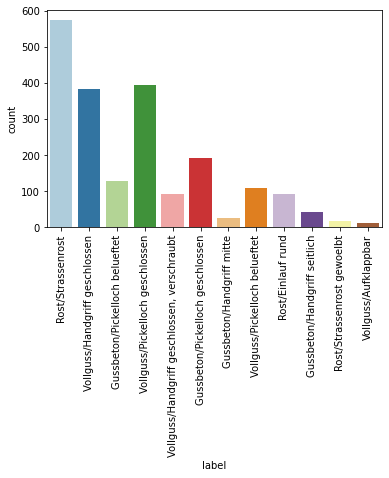

In [9]:
sns.countplot(x="label",data=df)
plt.xticks(rotation = 90)
plt.show()

In [10]:
pkl_url_file = "../utils/dataset/label_new.pkl"
root_dir = "../data/images_transformed/"

In [11]:
with open(pkl_url_file, 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [12]:
trainloader = get_dataloader(
    root_dir=root_dir,
    df=df[df.set =="train"],
    fp_label_translator=pkl_url_file,
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)



valloader = get_dataloader(
    root_dir=root_dir,
    df=df[df.set =="val"],
    fp_label_translator=pkl_url_file,
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)


testloader = get_dataloader(
    root_dir=root_dir,
    df=df[df.set =="test"],
    fp_label_translator=pkl_url_file,
    transformations=my_test_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=False
)

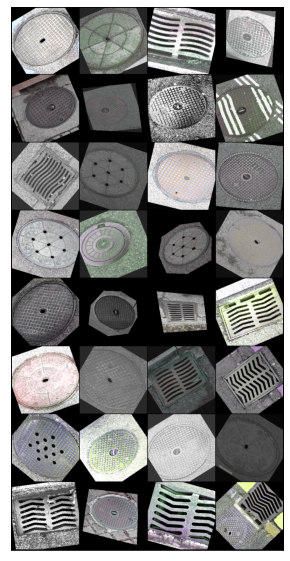

In [13]:
# Visualize one training batch
for images, labels in trainloader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

### Train

In [14]:
resnet152.train(criterion = criterion, optimizer = optimizer, n_epochs = n_epochs, dataloader_train = trainloader ,dataloader_val= valloader)

  0%|          | 0/10600 [00:00<?, ?it/s]

Epoch 1/200: [Train-Loss = 146.1] || [Validation-Loss = 16.178]
Epoch 2/200: [Train-Loss = 109.231] || [Validation-Loss = 34.805]
Epoch 3/200: [Train-Loss = 125.183] || [Validation-Loss = 13.212]
Epoch 4/200: [Train-Loss = 101.58] || [Validation-Loss = 14.207]
Epoch 5/200: [Train-Loss = 99.02] || [Validation-Loss = 10.747]
Epoch 6/200: [Train-Loss = 89.295] || [Validation-Loss = 12.025]
Epoch 7/200: [Train-Loss = 85.229] || [Validation-Loss = 10.818]
Epoch 8/200: [Train-Loss = 84.141] || [Validation-Loss = 10.258]
Epoch 9/200: [Train-Loss = 80.932] || [Validation-Loss = 10.499]
Epoch 10/200: [Train-Loss = 79.269] || [Validation-Loss = 16.943]
Epoch 11/200: [Train-Loss = 82.535] || [Validation-Loss = 9.536]
Epoch 12/200: [Train-Loss = 78.319] || [Validation-Loss = 12.833]
Epoch 13/200: [Train-Loss = 79.421] || [Validation-Loss = 9.108]
Epoch 14/200: [Train-Loss = 75.617] || [Validation-Loss = 12.427]
Epoch 15/200: [Train-Loss = 70.566] || [Validation-Loss = 9.444]
Epoch 16/200: [Train-L

In [15]:
y_true, y_pred, y_prob, y_images = resnet152.predict(testloader)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

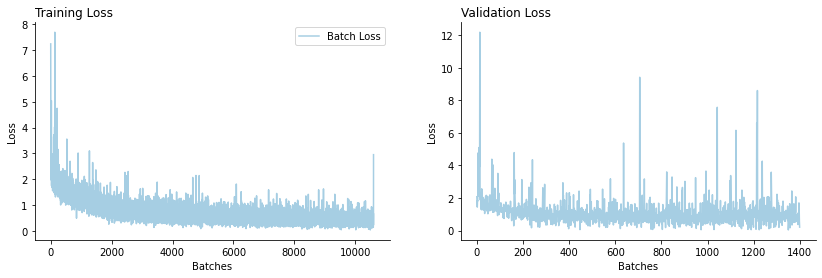

In [16]:
EvaluationPlots.plot_train_val_loss(resnet152.train_loss,resnet152.val_loss,)

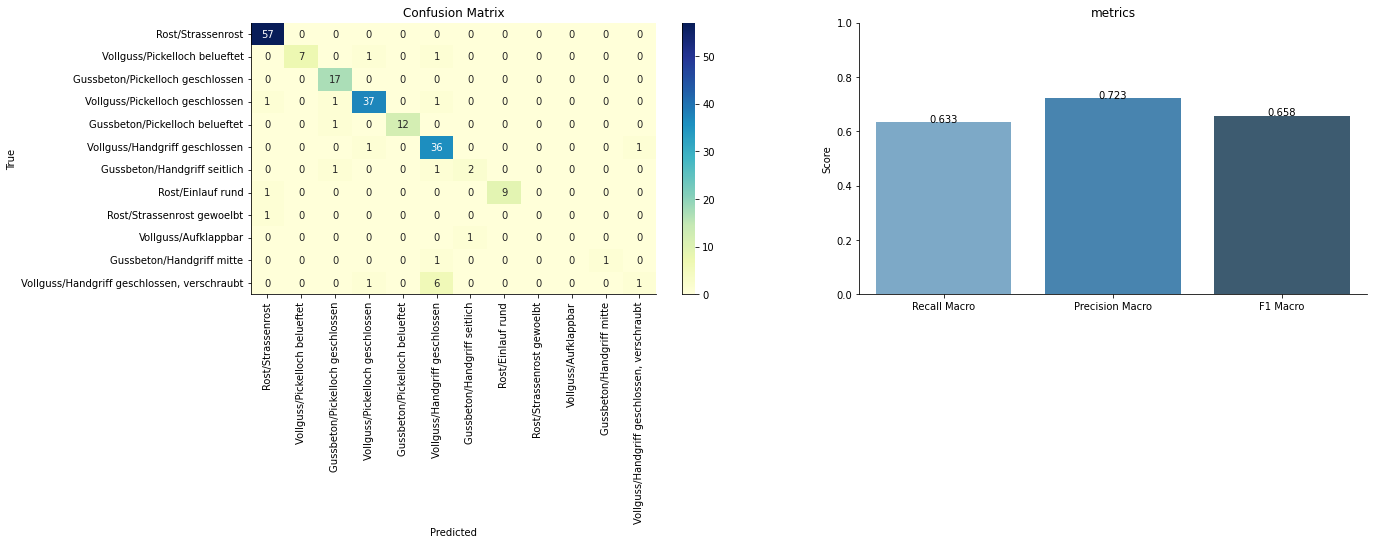

In [17]:
EvaluationPlots.metric_evaluation(y_true, y_pred,list(label_dict))

G:\Semester 6\Challenge X\manhole-cover-classification\model\..\utils\plots\plots.py:176: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  ax.imshow(image.T)


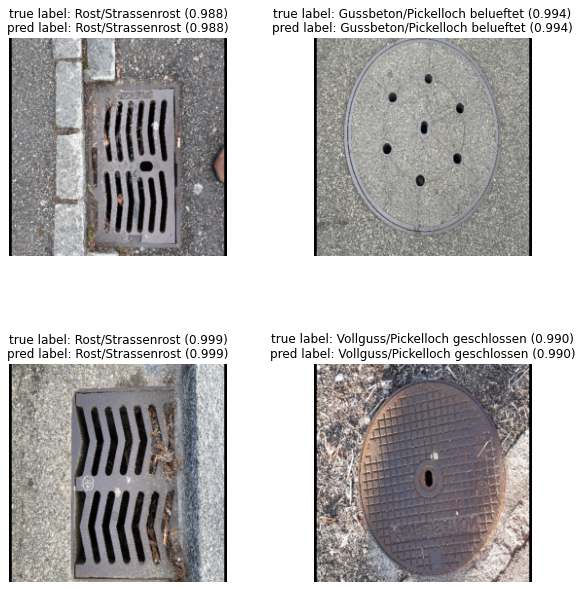

In [18]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,4, incorrect = False,label_dict=label_dict)

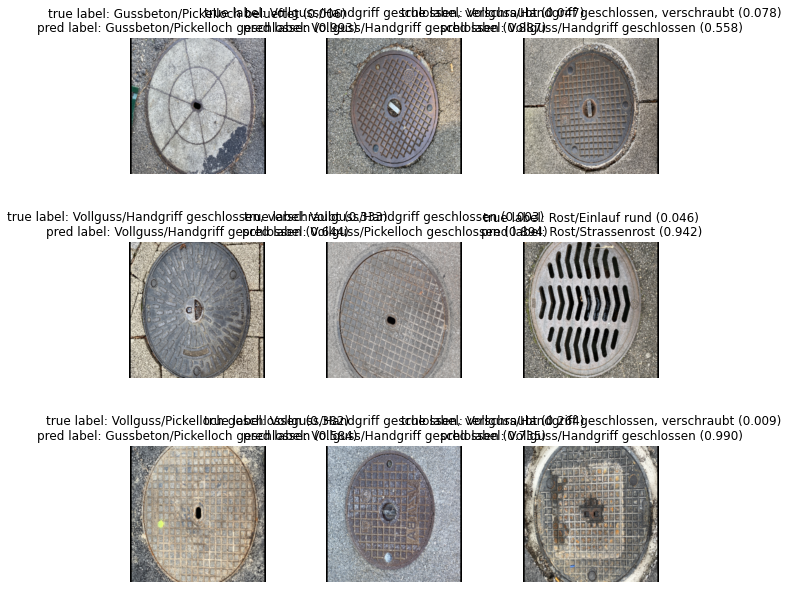

In [19]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,9, incorrect = True,label_dict=label_dict)

In [22]:
torch.save(resnet152, 'model_resnet152.pth')

In [23]:
model = torch.load('model_resnet152.pth')
model

In [24]:
df

,image,set,label,sub
0,100184900.png,train,Rost/Strassenrost,square
1,100034700.png,train,Rost/Strassenrost,square
2,100003200.png,train,Vollguss/Handgriff geschlossen,round
3,100004000.png,train,Gussbeton/Pickelloch belueftet,round
4,100125300.png,train,Vollguss/Handgriff geschlossen,round
...,...,...,...,...
2065,100136300.png,val,Rost/Strassenrost,square
2066,100018200.png,val,Vollguss/Pickelloch geschlossen,round
2067,100009400.png,val,Vollguss/Handgriff geschlossen,round
2068,100122000.png,val,Rost/Einlauf rund,round


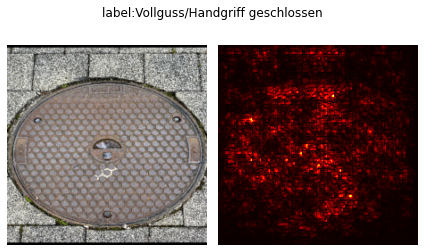

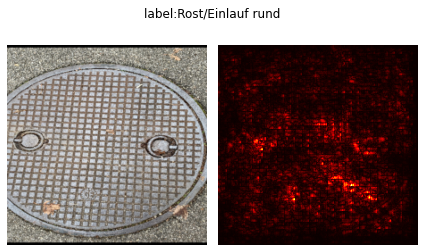

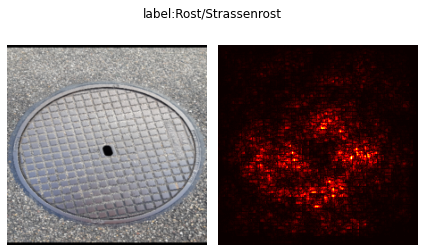

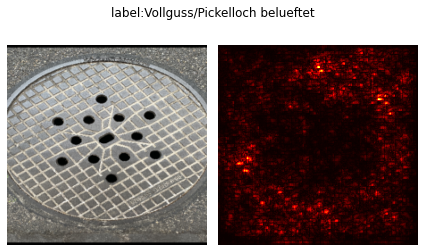

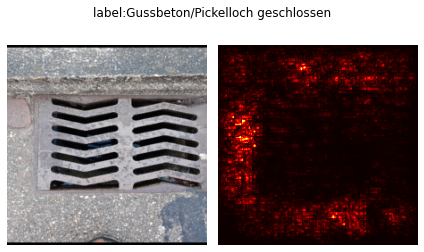

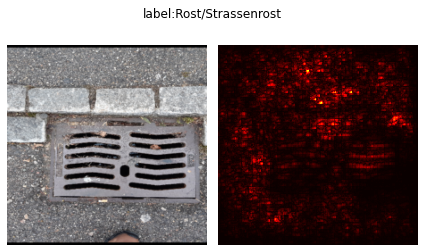

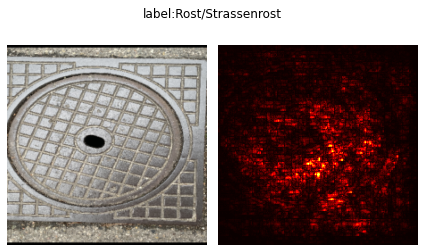

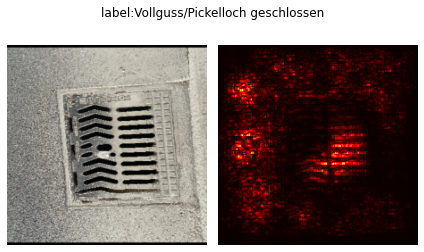

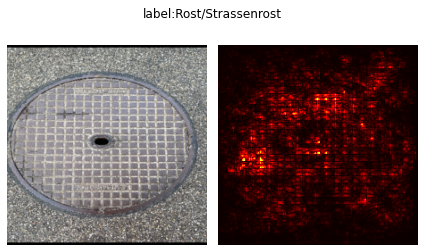

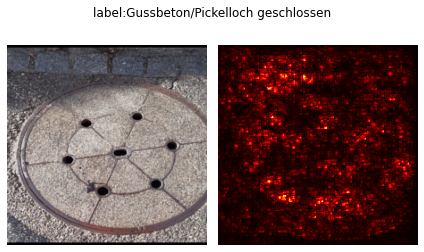

In [25]:
for i in range(10):
    imgg = "../data/images_transformed/"+list(df.sample()["image"])[0]
    image = PIL.Image.open(imgg)
    image = my_test_transforms(image)
    image = image.reshape(1, 3, 224, 224)
    image = image.to(device)
    image.requires_grad_()
    output = model.model(image)
    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)

    # Reshape the image
    image = image.reshape(-1, 224, 224)

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('label:'+list(df.sample()["label"])[0])
    plt.show()